### Переходим к практике

In [1]:
import pandas as pd
import numpy as np

from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from functools import lru_cache

from tqdm.notebook import tqdm_notebook, tqdm

#предобработка текстов
import re
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [2]:
tqdm_notebook.pandas()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Наши новости

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
# Анализатор морфологии слова - приводит к единой форме слова-производные(нпример: бежать, бегут, бегали, ... -> бегать)
morph = pymorphy2.MorphAnalyzer()

### Собираем stopwords

In [6]:
MANUAL_STOPWORDS = ['nn', 'nnn', 'этим', 'поэтому', 'это']
stopword_ru = stopwords.words('russian')

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru = stopword_ru + additional_stopwords + MANUAL_STOPWORDS
len(stopword_ru)

781

### Создание пайплайна для обработки поля с текстами

In [27]:
class TextCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, *args):
        print('Cleaning text')
        X[self.key] = X[self.key].progress_apply(self._clean_text)
        return X, self.key, *args
    
    def _clean_text(self, text):
        '''
        очистка текста    
        на выходе очищеный текст
        '''

        if not isinstance(text, str):
            text = str(text)

        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        text = re.sub('-\s\r\n\|-\s\r\n|\r\n', '', text)

        text = re.sub('[^\w\s]|[\d_]', '', text) # <=> re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)  # |(?<=[а-я])n+(?=[а-я]) - меняет 'n+' на ' ' внутри русс слов
        text = re.sub(r'[\xad]|[\s]+', ' ', text.strip())
        return text
    
    
class Lemmatizator(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X, key = X
        print('Lemmatization')
        X[key] = X[key].progress_apply(self._lemmatization_lrucache)
        return X, key
    
    @lru_cache(maxsize=None)
    def __lru_morph(self, word):
        return morph.parse(word)[0].normal_form

    def _lemmatization_lrucache(self, text):
        '''
        лемматизация
            [0] если зашел тип не `str` делаем его `str`
            [1] токенизация предложения через razdel
            [2] проверка есть ли в начале слова '-' 
            [3] проверка токена из одного символа
            [4] проверка есть ли данное слово в кэше
            [5] лемматизация слова
            [6] проверка на стоп-слова

        на выходе лист отлемматизированых токенов   
        '''

        if not isinstance(text, str):
            text = str(text)

        # [1] + [3]
        tokens = tokenize(text)
        words = [i.text for i in tokens if len(i.text) > 1]

        words_lem = []

        for w in words:
            if w[0] == '-': # [2]
                w = w[1:]
            
            words_lem.append(self.__lru_morph(w))  # [4] - за счет декоратора, [5]
        
        words_lem_without_stopwords = [i for i in words_lem if i not in stopword_ru] # [6]
        
        return words_lem_without_stopwords

    
class MakeCorpusAndDict(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.common_dictionary = None
        self.common_corpus = None
    
    def fit(self, X, y=None):
        # Сформируем список наших текстов, разбив еще и на пробелы
        X, key = X
        texts = [t for t in X[key].values]
        # Формируеи corpus(список списков, содержащих кортежи с индексами слов из словаря self.common_dictionary
        #  и колличеством этих слов. Сами списки - это переданные статьи)
        print('Creating dictionary')
        self.common_dictionary = Dictionary(tqdm(texts))
        # Creating corpus generator
        self.common_corpus = [self.common_dictionary.doc2bow(text) for text in texts]
        return self        
        
    def transform(self, X):
        return self, *X
    

class CommonLdaModel(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_topics=25, lda=None):
        self.num_topics = num_topics
        if lda:
            self.lda = lda 
        elif not hasattr(self, 'lda'):
            self.lda = None 
    
    def fit(self, X, y=None):
        X, df, key = X
        if not self.lda:
            print('Learning LDA model')
            self.lda = LdaModel(tqdm(X.common_corpus), id2word=X.common_dictionary, num_topics=self.num_topics)
        return self
        
    def transform(self, X):
#         X, df, key = X
        return self.lda, X[0].common_dictionary, X[1:]
    

# class VectorizingTexts(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, lda, common_dictionary):
    

prepare_text = Pipeline([('text_cleaner', TextCleaner(key='title')),
                         ('lemmatizator', Lemmatizator())], verbose=True)
                         
lda_model = Pipeline([('prepare_text', prepare_text),
                      ('corp_dict', MakeCorpusAndDict()),
                      ('lda_model', CommonLdaModel(num_topics=25))], verbose=True)

In [28]:
%%time
# tqdm.set_description(desc='progress: ')
news_ = news[:100].copy()
lda, common_dictionary, df = lda_model.fit_transform(news_)

# res = prepare_text.fit_transform(news_)

Cleaning text



[Pipeline] ...... (step 1 of 2) Processing text_cleaner, total=   0.0s
Lemmatization



[Pipeline] ...... (step 2 of 2) Processing lemmatizator, total=   0.7s
[Pipeline] ...... (step 1 of 3) Processing prepare_text, total=   0.7s
Creating dictionary



[Pipeline] ......... (step 2 of 3) Processing corp_dict, total=   0.0s
Learning LDA model



[Pipeline] ......... (step 3 of 3) Processing lda_model, total=   0.2s
Wall time: 936 ms


In [37]:
df

(    doc_id                                              title
 0        6  [заместитель, председатель, правительство, рф,...
 1     4896  [матч, финал, кубок, россия, футбол, приостано...
 2     4897  [форвард, авангард, томаш, заборский, прокомме...
 3     4898  [главный, тренер, кубань, юрий, красножанин, п...
 4     4899  [решение, попечительский, совет, владивостокск...
 ..     ...                                                ...
 95    4990  [мужской, сборная, новый, зеландия, регби, выи...
 96    4991  [генеральный, директор, фктомь, артём, фоменко...
 97    4992  [нападать, московский, спартак, артём, дзюба, ...
 98    4993  [полузащитник, александр, харитон, максим, аст...
 99    4994  [форвард, валерий, ничушкина, выбрать, драфт, ...
 
 [100 rows x 2 columns],
 'title')

In [45]:
# lda[common_dictionary.doc2bow(news_['title'][0])]
for i in lda[news_.title.apply(common_dictionary.doc2bow)]:
    print(i)

[(11, 0.9918629)]
[(17, 0.9771414)]
[(5, 0.979573)]
[(12, 0.98870325)]
[(11, 0.97538346)]
[(23, 0.44497326), (24, 0.5410839)]
[(6, 0.9709075)]
[(20, 0.9753834)]
[(18, 0.98426163)]
[(20, 0.98702615)]
[(11, 0.97176325)]
[(6, 0.23868313), (20, 0.7259256)]
[(12, 0.97333103)]
[(5, 0.15218583), (18, 0.82690144)]
[(14, 0.5228875), (20, 0.46433184)]
[(9, 0.96903014)]
[(12, 0.9818854)]
[(19, 0.983157)]
[(0, 0.079439364), (23, 0.90947413)]
[(17, 0.9834463)]
[(6, 0.99231935)]
[(23, 0.9906791)]
[(4, 0.37166303), (5, 0.6177597)]
[(4, 0.3459466), (8, 0.6407179)]
[(0, 0.97957325)]
[(18, 0.20402664), (24, 0.789256)]
[(4, 0.979129)]
[(22, 0.9804054)]
[(12, 0.98769146)]
[(0, 0.9818856)]
[(5, 0.9822204)]
[(22, 0.9747357)]
[(8, 0.39547917), (12, 0.5836086)]
[(22, 0.97176343)]
[(0, 0.98188555)]
[(0, 0.9839956)]
[(7, 0.9709084)]
[(6, 0.9932856)]
[(4, 0.97866607)]
[(10, 0.984761)]
[(0, 0.9825438)]
[(4, 0.9825445)]
[(0, 0.344179), (22, 0.6393906)]
[(17, 0.9709068)]
[(4, 0.590435), (14, 0.3903951)]
[(0, 0.9828

In [117]:
# df.apply(lambda x: [1, 2], axis=1, result_type='expand')
# df.apply(lambda x: [1, 2], axis=1, result_type='expand')
pd.set_option('max_columns', 25)
df[0][['title']].apply(get_lda_vector, axis=1, result_type='expand')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.991863,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.977141,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.979573,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.988703,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.975383,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.0,0.0,0.0,0.000000,0.973332,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.983999,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.979999,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.983157,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

In [9]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model_1.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [39]:
text = news_['title'].values[0]
corpus = common_dictionary.doc2bow(text)
lda[corpus]

[(4, 0.7282553), (18, 0.26393956)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [11]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news_['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(20, 0.9795723)]

In [12]:
x = lda.show_topics(num_topics=25, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic) + " ".join(words))

topic_0: команда весь выбрать матч победа клуб сборная
topic_1: матч сборная время команда всё год первый
topic_2: хороший бразилия команда свой испания который сборная
topic_3: матч команда чемпионат сбор зенит сезон провести
topic_4: стать клуб провести драфт матч совет сообщать
topic_5: команда который турнир клуб очень игра свой
topic_6: который команда клуб матч год играть слово
topic_7: клуб команда сезон выбрать матч желать российский
topic_8: матч очень игра приводить слово бразилия сборная
topic_9: сборная команда игра чемпионат матч игрок который
topic_10: клуб команда драфт выбрать гончар даллас который
topic_11: команда сборная матч ростов мочь мир кубок
topic_12: команда наш который футболист приводить слово драфт
topic_13: матч турнир команда очень игра победа думать
topic_14: выбрать который очень год клуб матч номер
topic_15: матч команда слово игра сборная ru очень
topic_16: молдавия сбор первый который томь июль тирасполь
topic_17: совет матч металлург ворскла турнир 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [109]:
def get_lda_vector(text, size=25):
    unseen_doc = common_dictionary.doc2bow(text.values[0])
    lda_tuple = lda[unseen_doc]
    
    output_vector = np.zeros(size)

    for k, v in lda_tuple:
        output_vector[k] = v

    return output_vector


In [82]:
pd.DataFrame(map(get_lda_vector, news_['title'].values))
# topics

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.977141,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.979573,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.0,0.0,0.0,0.0,0.000000,0.973332,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.979999,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.983157,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news_['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news_['doc_id'].values
topic_matrix = topic_matrix[['doc_id'] + ['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.99186,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,4896,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.977141,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.0,0.0,0.322745,0.0,0.178759,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,4898,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.975383,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [53]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [54]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [55]:
doc_dict[293622]

array([0.        , 0.03299396, 0.        , 0.02984287, 0.03467344,
       0.        , 0.        , 0.06806819, 0.04691479, 0.        ,
       0.28047207, 0.11233012, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03740891, 0.        , 0.34727663,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [56]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, agg_func=np.mean):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = agg_func(user_vector, 0)
    return user_vector

In [57]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.00316244, 0.04849131, 0.00915531,
       0.        , 0.        , 0.01489123, 0.00291479, 0.02941413,
       0.30918505, 0.03530298, 0.01551338, 0.00791914, 0.0191663 ,
       0.        , 0.        , 0.05975967, 0.00488473, 0.10060805,
       0.        , 0.06709802, 0.        , 0.05396198, 0.20173113])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [58]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [73]:
" ".join(news_[news_['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [60]:
user_embeddings = [] 
for funk in [np.mean, np.median, np.max]:
    user_embeddings_temp = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
    user_embeddings_temp.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings_temp['uid'] = users['uid'].values
    user_embeddings_temp = user_embeddings_temp[['uid']+['topic_{}'.format(i) for i in range(25)]]
    user_embeddings.append(user_embeddings_temp)
    
# user_embeddings.head(3)

Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [61]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [62]:
X_dict = {}
for i, user_embedding in enumerate(user_embeddings):
    X_dict[i] = pd.merge(user_embedding, target, 'left')
#     X.head(3)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [64]:
#разделим данные на train/test

X_train, X_test, y_train, y_test = train_test_split(X_dict[1][['topic_{}'.format(i) for i in range(25)]], 
                                                    X_dict[1]['churn'], random_state=0)

In [65]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [66]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.20891475, 0.10296304, 0.3004363 , 0.22272783, 0.08323747,
       0.08293715, 0.2890588 , 0.02618986, 0.09933771, 0.11723052])

In [67]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [68]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.200691, F-Score=0.620, Precision=0.524, Recall=0.759


In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1586  169]
 [  60  185]]


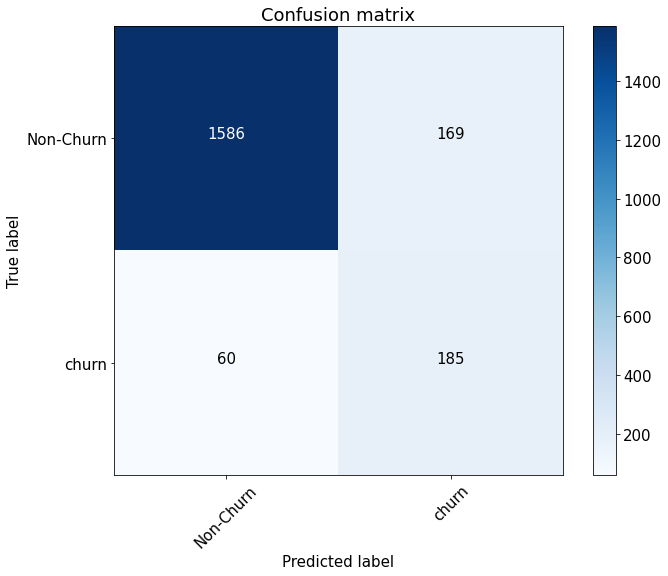

In [70]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
roc_auc_score(y_test, preds)

0.9276725391011105

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 